# Demo Whitespace DecisionTreeExtractionAI

In this notebook we will see how to use the Konfuzio SDK to to train a model to find and extract relevant information like Name, Date and Recipient from payslip documents. 

Here we will see how to use the basic Konfuzio information extraction pipeline.

## Setting things up

First, we need to install and initialize the konfuzio_sdk package. See [here](https://github.com/konfuzio-ai/konfuzio-sdk) for more info.

In [1]:
# !pip install konfuzio-sdk

In [2]:
# !konfuzio_sdk init

We also need to import the required packages. 

In [3]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..')) # for tests import

import konfuzio_sdk
from konfuzio_sdk.data import Project
from konfuzio_sdk.trainer.information_extraction import DocumentEntityMulticlassModel
from konfuzio_sdk.tokenizer.regex import WhitespaceTokenizer
from konfuzio_sdk.api import upload_ai_model

/tmp/ipykernel_233539/475306060.py:7: FutureWarning: This module is WIP: https://gitlab.com/konfuzio/objectives/-/issues/9311
  from konfuzio_sdk.trainer.information_extraction import DocumentEntityMulticlassModel


## Initializing the project and the training pipeline

Now we can load the Konfuzio project. Here we use a simple offline project included in the tests for the Konfuzio SDK. We can find it in the `OFFLINE_PROJECT` folder.

In [4]:
from tests.variables import OFFLINE_PROJECT, TEST_DOCUMENT_ID

We now can initialize the project. Since we're working with a local project, we don't need to specify a project `id_`. If you're working with a Project that can be found on the Konfuzio platform, you can just specify the `id_` of the Project and then start working with it in your local setup. 

In [5]:
project = Project(id_=None, project_folder=OFFLINE_PROJECT)

Each project has one or more categories which will tell us how to process the documents belonging to that category. Here we only have one category: `Lohnabrechnung` (i.e. payslip).

In [6]:
project.categories

[Lohnabrechnung (63)]

In [7]:
category = project.categories[0]

Now we can initialize the training pipeline. Here we use the `DocumentEntityMulticlassModel` class.

The model is composed of a Label and Label Set classifier both using a [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from scikit-learn. Our approach is inspired by [Sun et al. (2021)](https://arxiv.org/abs/2103.14470)

We first split the text of the Document into smaller chunks of text based on whitespaces and then use a combination of features to train the first Label classifier to assign labels to these chunks of text.

After the Label classifier, the Label Set classifier takes the predictions from the Label classifier as input. The Label Set classifier groups Annotations them into Annotation sets.

In [8]:
pipeline = DocumentEntityMulticlassModel()
pipeline.category = category

We can also set the pipeline `test_documents` attribute. This will be used to evaluate our model later on. In this project we have 3 test documents.

In [9]:
pipeline.test_documents = project.test_documents
pipeline.test_documents

[Document Auswertungspaket - unterschiedliche B_N-Auswertungen.pdf_18.pdf (44865),
 Document Auswertungspaket - unterschiedliche B_N-Auswertungen.pdf_17.pdf (44866),
 Document Auswertungspaket - unterschiedliche B_N-Auswertungen.pdf_19.pdf (44867)]

Now it's time to look at our training documents.

In [10]:
documents = project.documents

In [11]:
# check if all documents are assigned a category
for doc in documents:
    if doc.category is None:
        print(doc, 'No Category!')

Document 2022-02-13 16:19:30.684745 (44864) No Category!


In [12]:
# filtering out the document with no category
documents = [doc for doc in documents if doc.category is not None]

We have 25 training documents we can use to train our classifier. 

In [13]:
len(documents)

25

Let's have a look at what exactly a document in this dataset looks like. 

In [14]:
document = documents[0]

In [15]:
document.text

"                                                            x02   328927/10103/00104\nAbrechnung  der Brutto/Netto-Bezüge   für Dezember 2018                   22.05.2018 Bat:  1\n \nPersonal-Nr.  Geburtsdatum ski Faktor  Ki,Frbtr.Konfession  ‚Freibetragjährl.! |Freibetrag mt! |DBA  iGleitzone  'St.-Tg.  VJuUr. üb. |Url. Anspr. Url.Tg.gen.  |Resturlaub\n00104 150356 1  |     ‚ev                              30     400  3000       3400\n \nSV-Nummer       |Krankenkasse                       KK%®|PGRS Bars  jum.SV-Tg. Anw. Tage |UrlaubTage Krankh. Tg. Fehlz. Tage\n                                             \n50150356B581 AOK  Bayern Die Gesundheitskas 157 101 1111 1 30\n \n                                             Eintritt   ‚Austritt     Anw.Std.  Urlaub Std.  |Krankh. Std. |Fehlz. Std.\n                                             \n                                             170299  L L       l     L     l     l\n -                                       +  Steuer-ID       IMrB?

This is the output of Optical Character Recognition (OCR) model on the following image:

[Page 0 in Document Gehalt.pdf (44823)]


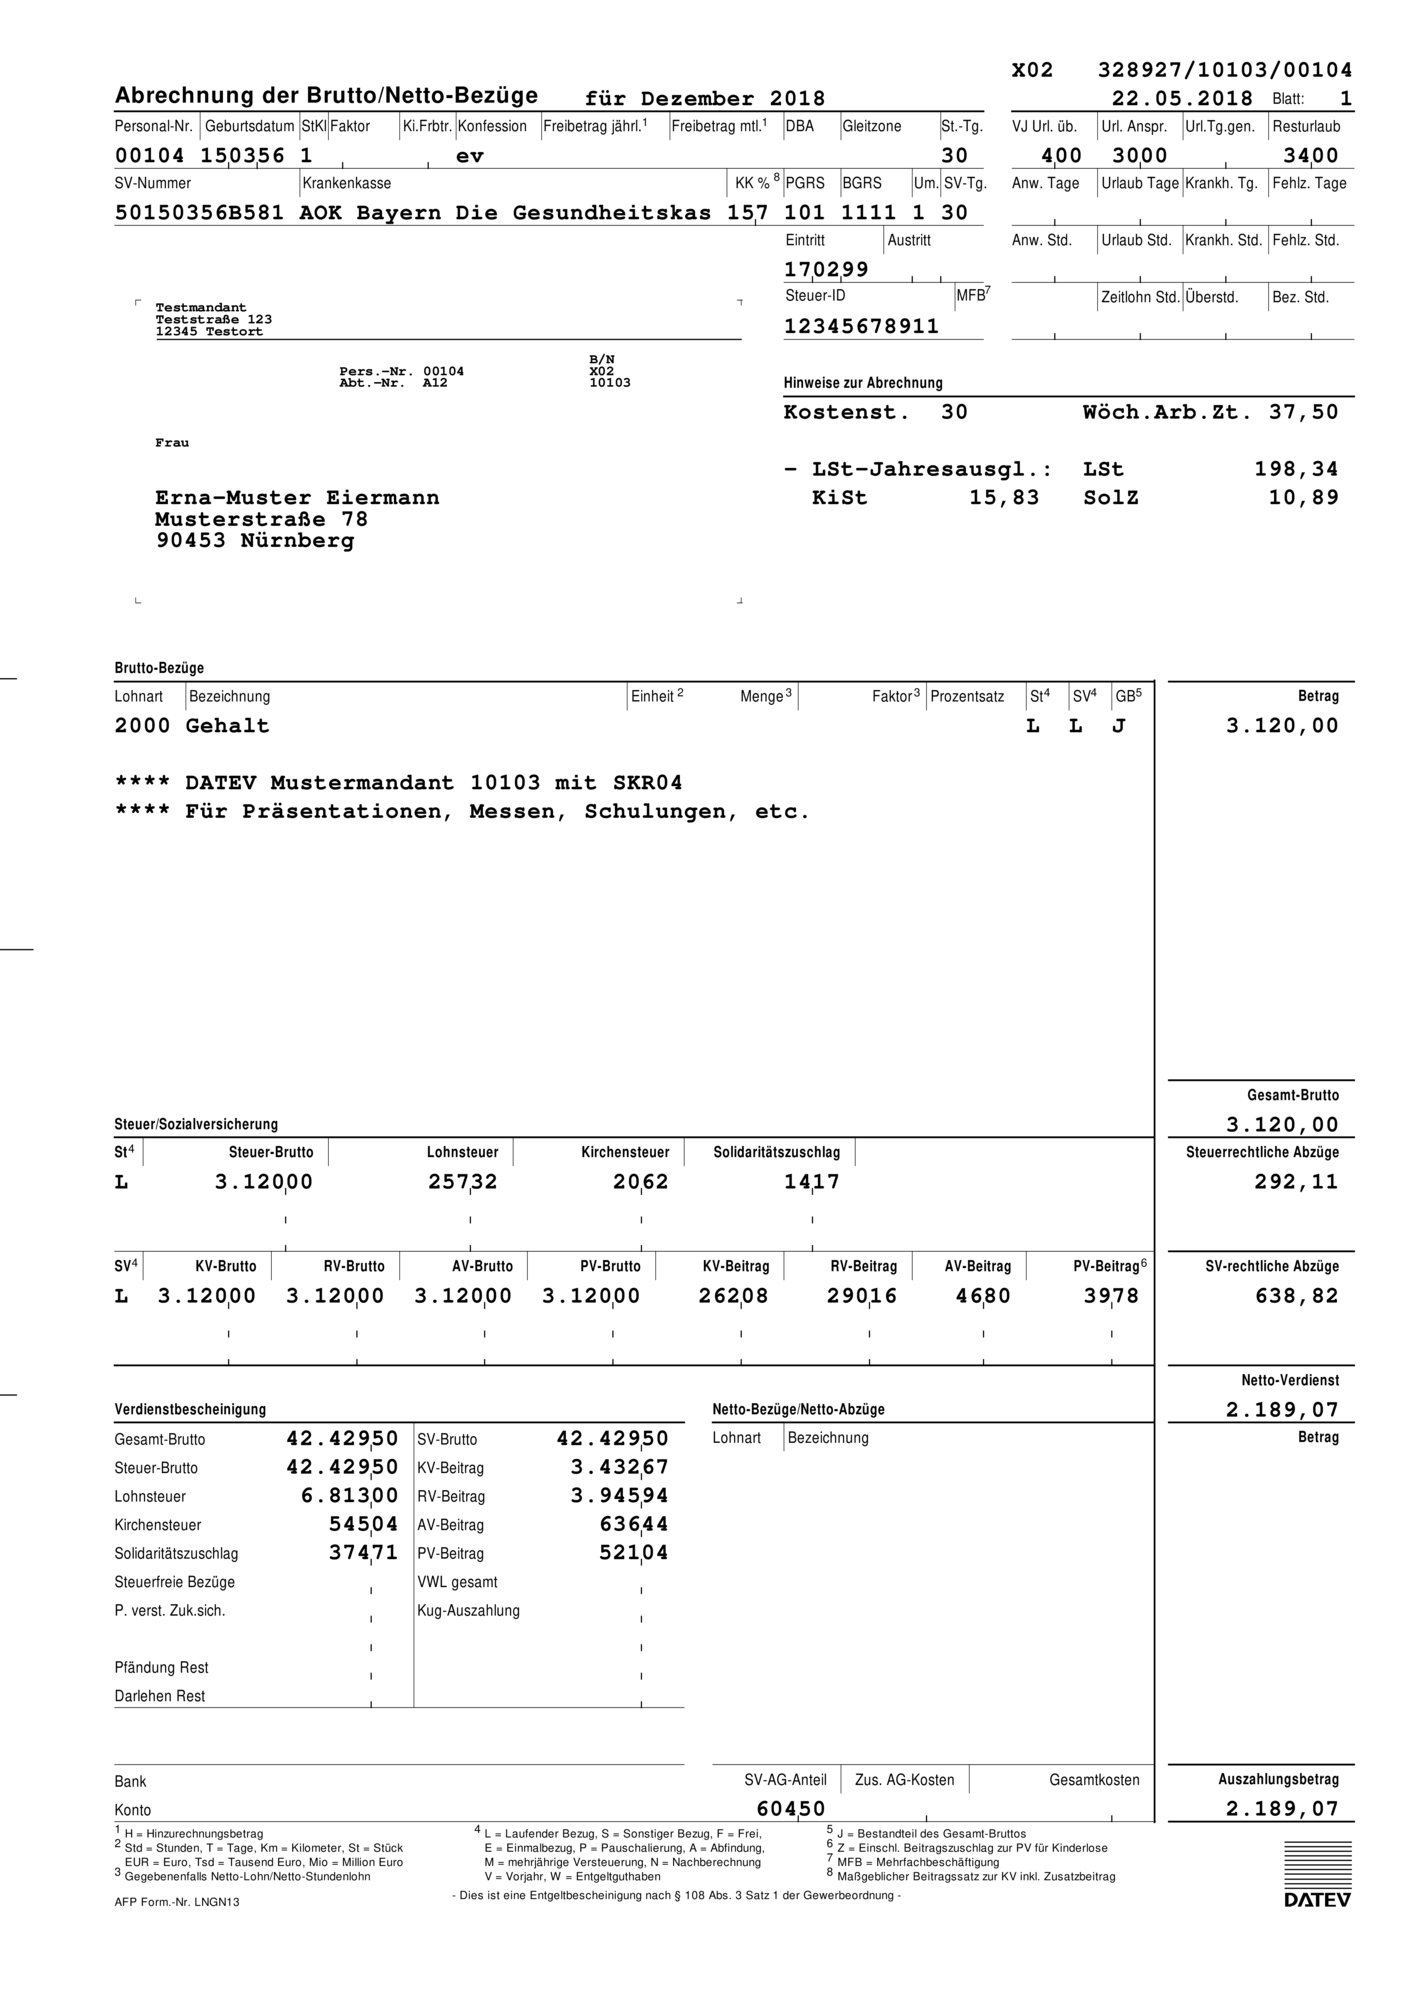

In [16]:
print(document.pages())
document.pages()[0].get_image()

And those are the annotations we want to find:

In [17]:
document.annotations()

[Annotation (https://app.konfuzio.com/a/12516017/) Austellungsdatum (66, 78), (159, 169),
 Annotation (https://app.konfuzio.com/a/9585450/) Personalausweis (352, 357),
 Annotation (https://app.konfuzio.com/a/4420022/) Steuerklasse (365, 366),
 Annotation (https://app.konfuzio.com/a/9609649/) Personalausweis (1194, 1199),
 Annotation (https://app.konfuzio.com/a/9812334/) Gesamt-Brutto (1498, 1504), (1582, 1587),
 Annotation (https://app.konfuzio.com/a/4420057/) Vorname (1507, 1518),
 Annotation (https://app.konfuzio.com/a/4420245/) Nachname (1519, 1527),
 Annotation (https://app.konfuzio.com/a/4420346/) Lohnart (1758, 1762),
 Annotation (https://app.konfuzio.com/a/4420348/) Bezeichnung (1763, 1769),
 Annotation (https://app.konfuzio.com/a/11613686/) Betrag (1831, 1839),
 Annotation (https://app.konfuzio.com/a/4420363/) Gesamt-Brutto (2111, 2119),
 Annotation (https://app.konfuzio.com/a/9585509/) Sozialversicherung (2255, 2262),
 Annotation (https://app.konfuzio.com/a/9585548/) Sozialver

Documents in this category may include the following fields:

In [18]:
for label in category.labels:
    print(label.name)

Lohnart
NO_LABEL
Nachname
Faktor
Personalausweis
Gesamt-Brutto
Vorname
Austellungsdatum
Sozialversicherung
Bank inkl. IBAN
Steuerrechtliche Abzüge
Steuer-Brutto
Menge
Steuerklasse
Netto-Verdienst
Bezeichnung
Betrag
EMPTY_LABEL
Auszahlungsbetrag


This is all the information we may want to identify in documents of this category.

## Set the Whitespace Tokenizer

Now we need to decide how we will segment our text for entity detection and classification. In this example we will use a simple WhiteSpace tokenizer. It will seperate text segments by whitespace and allow us to label each individual segment. 

In [19]:
pipeline.tokenizer = WhitespaceTokenizer()

In [20]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

To train our label classifier, we first need to extract all the features for each segment of text, which will allow the classifier to automatically detect where the relevant information is. These include features about the text in a segment, its position on the page and its relation with and features about nearby segments of text.

In [21]:
%%capture
# Extract features
pipeline.df_train, pipeline.label_feature_list = pipeline.feature_function(documents=documents)

In [22]:
pipeline.df_train.shape

(7825, 355)

{{ len(pipeline.label_feature_list) }} is the number of features we use to classify each annotation.

In [23]:
len(pipeline.label_feature_list)

270

Now we're ready to do train our classifier:

In [24]:
  # Start to train the Classifier.
pipeline.fit()

RandomForestClassifier(class_weight='balanced', max_depth=100, random_state=420)

## Evaluation
And now we can evaluate our classifier like this.

In [25]:
%%capture
evaluation = pipeline.evaluate_full()

This will return an Evaluation object with all the relevant evaluation stats like the [F1-score](https://en.wikipedia.org/wiki/F-score):

In [26]:
print('F1', evaluation.f1(None))
print('tp', evaluation.tp(None))
print('fp', evaluation.fp(None))
print('fn', evaluation.fn(None))
print('tn', evaluation.tn(None))

F1 0.9237668161434978
tp 103
fp 17
fn 0
tn 0


### Display

We can also show the output of the model for visual inspection.

In [27]:
%%capture
from konfuzio_sdk.trainer.information_extraction import extraction_result_to_document
test_document = project.get_document_by_id(TEST_DOCUMENT_ID)

virtual_doc = extraction_result_to_document(test_document, pipeline.extract(test_document))

We'll use the [Pillow](https://pillow.readthedocs.io/en/stable/) library to show the output on the image of the document.

In [28]:
from PIL import Image, ImageDraw, ImageFont

Now we can see what the model has learned:

/home/sam-konf/Konfuzio/konfuzio-sdk/notebooks/../konfuzio_sdk/data.py:157: FutureWarning: WIP: Modifications before the next stable release expected.
  scale_mult * ann.spans[0].bbox().x0,
/home/sam-konf/Konfuzio/konfuzio-sdk/notebooks/../konfuzio_sdk/data.py:936: FutureWarning: WIP: Modifications before the next stable release expected.
  characters = {key: document.bboxes.get(key) for key in character_range if document.text[key] != ' '}


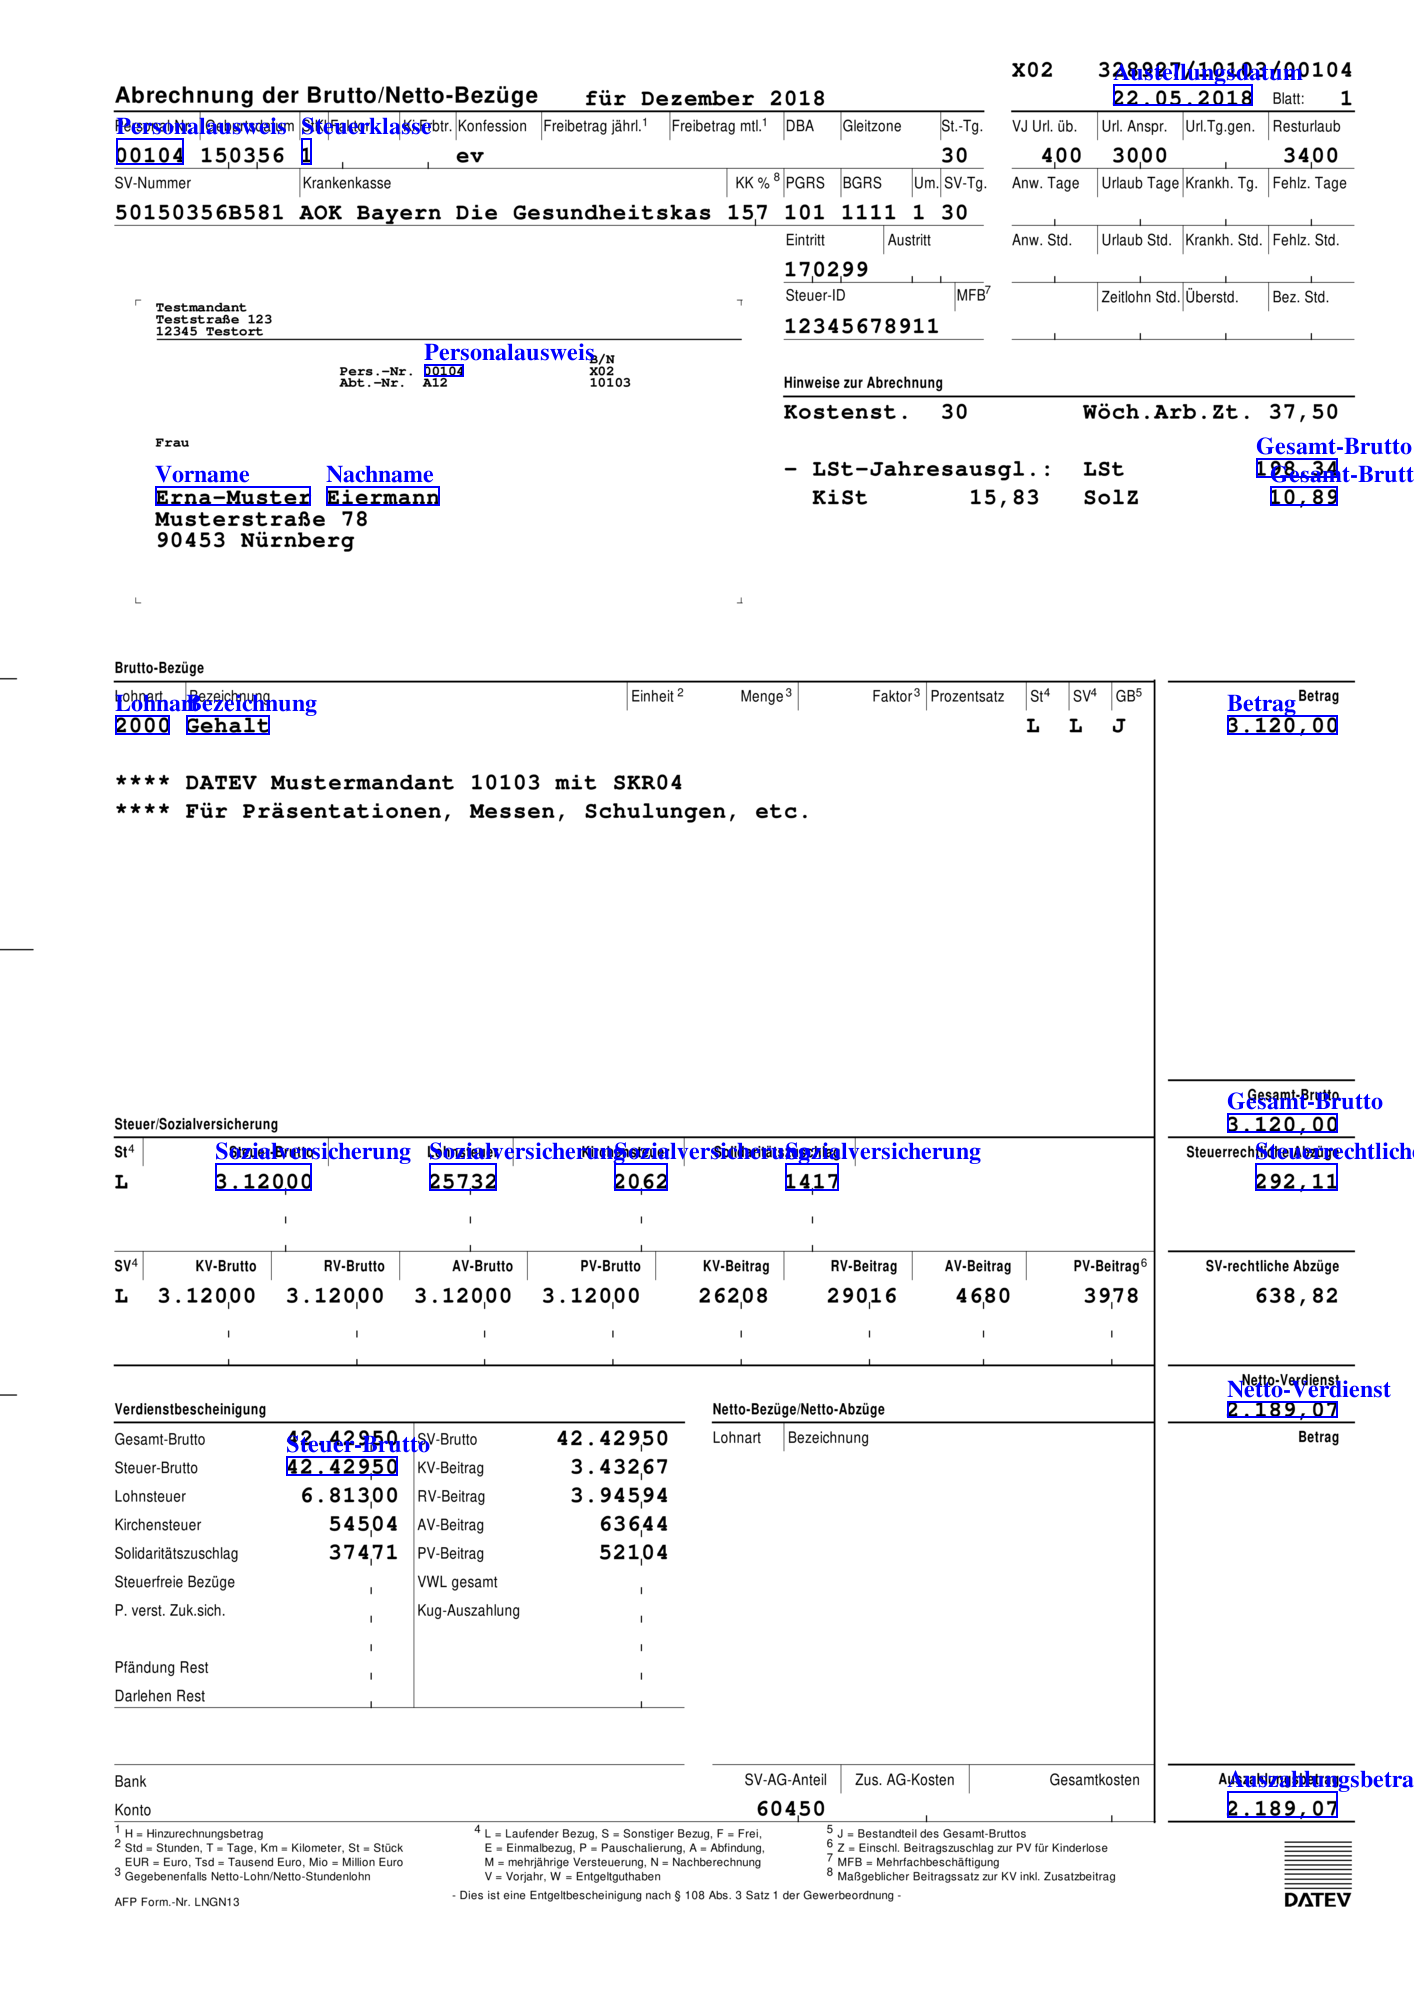

In [29]:
virtual_doc.pages()[0].get_annotations_image()

You may also upload the model to the Konfuzio platform and view extraction results with the Konfuzio SmartView.

And now we can save the trained Annotation classifier:

In [ ]:
pipeline_path = pipeline.save(output_dir=project.model_folder)
pipeline_path

You can only upload your Annotation classifier to your own instance of the Konfuzio Server. Please [contact](https://konfuzio.com/en/contact/) our sales if you want to install Konfuzio Server.

In [ ]:
upload_ai_model(ai_model_path=pipeline_path)